In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import wordpunct_tokenize
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding, Input, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Ensure TensorFlow is using the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        tf.config.experimental.set_visible_devices(physical_devices, 'GPU')
    except:
        pass

# Function to train and evaluate the model
def train_evaluate_model(model, X_train, X_test, y_train, y_test, results_folder, feature_count, model_name):
    checkpoint_path = os.path.join(results_folder, f"{model_name}_{feature_count}_best_model.keras")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss')
    ]

    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=callbacks)
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # Calculate evaluation metrics
    accuracy = round(accuracy_score(y_test, y_pred), 2) * 100
    precision = round(precision_score(y_test, y_pred), 2) * 100
    recall = round(recall_score(y_test, y_pred), 2) * 100
    f1 = round(f1_score(y_test, y_pred), 2) * 100
    kappa = round(cohen_kappa_score(y_test, y_pred), 2) * 100

    # Print evaluation metrics
    print(f"Results for {feature_count} features with {model_name}:")
    print(f"Accuracy: {accuracy}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"F1 Score: {f1}%")
    print(f"Cohen Kappa: {kappa}%")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {feature_count} features with {model_name}:")
    print(cm)

    # Save confusion matrix plot
    fig, ax = plt.subplots(figsize=(10, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(f"Confusion Matrix for {feature_count} features with {model_name}")
    plt.savefig(os.path.join(results_folder, f"confusion_matrix_{model_name}_{feature_count}_features.png"), dpi=300)
    plt.close()

    # Save results to CSV
    results = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Cohen Kappa'],
        'Value': [accuracy, precision, recall, f1, kappa]
    }
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(results_folder, f'results_{model_name}_{feature_count}_features.csv'), index=False)

    # Save training and validation accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy for {feature_count} features')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(os.path.join(results_folder, f'{model_name}_accuracy_{feature_count}_features.png'), dpi=300)
    plt.close()

    plt.figure(figsize=(10, 7))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss for {feature_count} features')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.savefig(os.path.join(results_folder, f'{model_name}_loss_{feature_count}_features.png'), dpi=300)
    plt.close()

# Define the Bi-LSTM model
def create_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, input_shape=input_shape)),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
    return model

# Load the dataset
file_path = 'preprocessed_ut20k.csv'
dataset = pd.read_csv(file_path)

# Ensure no NaN values in 'comment' column
dataset.dropna(subset=['comment'], inplace=True)

# Split the dataset into features and labels
X = dataset['comment']
y = dataset['label']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# Label Encoder
encoder = LabelEncoder()

# Transform train and test labels
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Define custom stop words
freezing_words = ['ہے', 'ہیں', 'تھا', 'تھے', 'کے']

# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(
    analyzer='word',
    max_df=0.8,
    min_df=4,
    ngram_range=(1, 1),
    stop_words=freezing_words,
    sublinear_tf=True,
    tokenizer=wordpunct_tokenize
)

# Fit and transform the training data, then transform the testing data
train_data_x = tfidf.fit_transform(X_train)
test_data_x = tfidf.transform(X_test)

# Select a feature size
feature_size = train_data_x.shape[1]

# Feature selection using chi2
chi2_fs = SelectKBest(chi2, k=feature_size)
X_train_k = chi2_fs.fit_transform(train_data_x, y_train)
X_test_k = chi2_fs.transform(test_data_x)

# Convert sparse matrices to dense arrays
X_train_k = X_train_k.toarray()
X_test_k = X_test_k.toarray()

# Reshape data for Bi-LSTM input
X_train_k = X_train_k.reshape((X_train_k.shape[0], 1, X_train_k.shape[1]))
X_test_k = X_test_k.reshape((X_test_k.shape[0], 1, X_test_k.shape[1]))

# Create results folder
results_folder = os.path.join("results", f"BiLSTM_{feature_size}_features")
os.makedirs(results_folder, exist_ok=True)

# Define and train the Bi-LSTM model
bilstm_model = create_bilstm((1, X_train_k.shape[2]))
train_evaluate_model(bilstm_model, X_train_k, X_test_k, y_train, y_test, results_folder, feature_size, "BiLSTM")


/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.5760 - loss: 0.7363 - val_accuracy: 0.8493 - val_loss: 0.3945
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8785 - loss: 0.3533 - val_accuracy: 0.8462 - val_loss: 0.3800
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9150 - loss: 0.2647 - val_accuracy: 0.8357 - val_loss: 0.4043
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9359 - loss: 0.2183 - val_accuracy: 0.8349 - val_loss: 0.4563
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9523 - loss: 0.1641 - val_accuracy: 0.8290 - val_loss: 0.4871
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9592 - loss: 0.1497 - val_accuracy: 0.8210 - val_loss: 0.5592
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9640 - loss: 0.1305 - val_accuracy: 0.8160 - val_loss: 0.5791
Training time: 52.33 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Results for 6243 features

In [3]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import wordpunct_tokenize
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Ensure TensorFlow is using the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        tf.config.experimental.set_visible_devices(physical_devices, 'GPU')
    except:
        pass

# Function to train and evaluate the model
def train_evaluate_model(model, X_train, X_test, y_train, y_test, results_folder, feature_count, model_name):
    checkpoint_path = os.path.join(results_folder, f"{model_name}_{feature_count}_best_model.keras")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss')
    ]

    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=callbacks)
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # Calculate evaluation metrics
    accuracy = round(accuracy_score(y_test, y_pred), 2) * 100
    precision = round(precision_score(y_test, y_pred), 2) * 100
    recall = round(recall_score(y_test, y_pred), 2) * 100
    f1 = round(f1_score(y_test, y_pred), 2) * 100
    kappa = round(cohen_kappa_score(y_test, y_pred), 2) * 100

    # Print evaluation metrics
    print(f"Results for {feature_count} features with {model_name}:")
    print(f"Accuracy: {accuracy}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"F1 Score: {f1}%")
    print(f"Cohen Kappa: {kappa}%")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {feature_count} features with {model_name}:")
    print(cm)

    # Save confusion matrix plot
    fig, ax = plt.subplots(figsize=(10, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(f"Confusion Matrix for {feature_count} features with {model_name}")
    plt.savefig(os.path.join(results_folder, f"confusion_matrix_{model_name}_{feature_count}_features.png"), dpi=300)
    plt.close()

    # Save results to CSV
    results = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Cohen Kappa'],
        'Value': [accuracy, precision, recall, f1, kappa]
    }
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(results_folder, f'results_{model_name}_{feature_count}_features.csv'), index=False)

    # Save training and validation accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy for {feature_count} features')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(os.path.join(results_folder, f'{model_name}_accuracy_{feature_count}_features.png'), dpi=300)
    plt.close()

    plt.figure(figsize=(10, 7))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss for {feature_count} features')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.savefig(os.path.join(results_folder, f'{model_name}_loss_{feature_count}_features.png'), dpi=300)
    plt.close()

# Define the Bi-LSTM model
def create_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, input_shape=input_shape)),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
    return model

# Load the dataset
file_path = 'preprocessed_ut20k.csv'
dataset = pd.read_csv(file_path)

# Ensure no NaN values in 'comment' column
dataset.dropna(subset=['comment'], inplace=True)

# Split the dataset into features and labels
X = dataset['comment']
y = dataset['label']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# Label Encoder
encoder = LabelEncoder()

# Transform train and test labels
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Define custom stop words
freezing_words = ['ہے', 'ہیں', 'تھا', 'تھے', 'کے']

# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(
    analyzer='word',
    max_df=0.8,
    min_df=4,
    ngram_range=(1, 1),
    stop_words=freezing_words,
    sublinear_tf=True,
    tokenizer=wordpunct_tokenize
)

# Fit and transform the training data, then transform the testing data
train_data_x = tfidf.fit_transform(X_train)
test_data_x = tfidf.transform(X_test)

# Feature selection and evaluation for different feature sizes
feature_sizes = [500, 1000, 1500, 2000, train_data_x.shape[1]]

for k in feature_sizes:
    results_folder = os.path.join("results", f"BiLSTM_{k}_features")
    os.makedirs(results_folder, exist_ok=True)

    # Feature selection using chi2
    chi2_fs = SelectKBest(chi2, k=k)
    X_train_k = chi2_fs.fit_transform(train_data_x, y_train)
    X_test_k = chi2_fs.transform(test_data_x)

    # Convert sparse matrices to dense arrays
    X_train_k = X_train_k.toarray()
    X_test_k = X_test_k.toarray()

    # Reshape data for Bi-LSTM input
    X_train_k = X_train_k.reshape((X_train_k.shape[0], 1, X_train_k.shape[1]))
    X_test_k = X_test_k.reshape((X_test_k.shape[0], 1, X_test_k.shape[1]))

    # Define and train the Bi-LSTM model
    bilstm_model = create_bilstm((1, X_train_k.shape[2]))
    train_evaluate_model(bilstm_model, X_train_k, X_test_k, y_train, y_test, results_folder, k, "BiLSTM")


/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Epoch 1/20


/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.5258 - loss: 0.7549 - val_accuracy: 0.8294 - val_loss: 0.4256
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8394 - loss: 0.4173 - val_accuracy: 0.8450 - val_loss: 0.3815
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8481 - loss: 0.3799 - val_accuracy: 0.8466 - val_loss: 0.3718
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8551 - loss: 0.3599 - val_accuracy: 0.8456 - val_loss: 0.3677
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8623 - loss: 0.3412 - val_accuracy: 0.8456 - val_loss: 0.3665
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8582 - loss: 0.3403 - val_accuracy: 0.8458 - val_loss: 0.3655
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8581 - loss: 0.3404 - val_accuracy: 0.8443 - val_loss: 0.3675
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8577 - loss: 0.3325 - val_accuracy: 0.84

/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.5753 - loss: 0.7388 - val_accuracy: 0.8419 - val_loss: 0.4071
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8520 - loss: 0.3882 - val_accuracy: 0.8497 - val_loss: 0.3728
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8683 - loss: 0.3437 - val_accuracy: 0.8495 - val_loss: 0.3672
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8806 - loss: 0.3180 - val_accuracy: 0.8493 - val_loss: 0.3708
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8825 - loss: 0.3074 - val_accuracy: 0.8480 - val_loss: 0.3695
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8923 - loss: 0.2847 - val_accuracy: 0.8468 - val_loss: 0.3722
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8913 - loss: 0.2838 - val_accuracy: 0.8417 - val_loss: 0.3771
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8895 - loss: 0.2852 - val_accuracy: 0.84

/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.5877 - loss: 0.7413 - val_accuracy: 0.8448 - val_loss: 0.4067
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8635 - loss: 0.3674 - val_accuracy: 0.8528 - val_loss: 0.3666
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8800 - loss: 0.3181 - val_accuracy: 0.8488 - val_loss: 0.3710
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8972 - loss: 0.2828 - val_accuracy: 0.8464 - val_loss: 0.3736
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8945 - loss: 0.2804 - val_accuracy: 0.8439 - val_loss: 0.3832
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8981 - loss: 0.2656 - val_accuracy: 0.8388 - val_loss: 0.3865
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9043 - loss: 0.2536 - val_accuracy: 0.8406 - val_loss: 0.3891
Training time: 48.03 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Results for 1500 features

/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.5452 - loss: 0.7438 - val_accuracy: 0.8382 - val_loss: 0.4268
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8607 - loss: 0.3835 - val_accuracy: 0.8513 - val_loss: 0.3747
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8867 - loss: 0.3120 - val_accuracy: 0.8484 - val_loss: 0.3730
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8986 - loss: 0.2798 - val_accuracy: 0.8427 - val_loss: 0.3822
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9134 - loss: 0.2529 - val_accuracy: 0.8429 - val_loss: 0.3825
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9120 - loss: 0.2558 - val_accuracy: 0.8370 - val_loss: 0.3970
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9094 - loss: 0.2422 - val_accuracy: 0.8411 - val_loss: 0.4050
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9144 - loss: 0.2308 - val_acc

/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.5436 - loss: 0.7449 - val_accuracy: 0.8355 - val_loss: 0.4379
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8680 - loss: 0.3708 - val_accuracy: 0.8441 - val_loss: 0.3794
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9093 - loss: 0.2775 - val_accuracy: 0.8376 - val_loss: 0.3994
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9368 - loss: 0.2136 - val_accuracy: 0.8329 - val_loss: 0.4335
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9480 - loss: 0.1785 - val_accuracy: 0.8298 - val_loss: 0.4804
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9567 - loss: 0.1518 - val_accuracy: 0.8167 - val_loss: 0.5260
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9659 - loss: 0.1267 - val_accuracy: 0.8128 - val_loss: 0.5979
Training time: 51.43 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Results for 6243 features

# LSTM

In [4]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import wordpunct_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Ensure TensorFlow is using the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        tf.config.experimental.set_visible_devices(physical_devices, 'GPU')
    except:
        pass

# Function to train and evaluate the model
def train_evaluate_model(model, X_train, X_test, y_train, y_test, results_folder, feature_count, model_name):
    checkpoint_path = os.path.join(results_folder, f"{model_name}_{feature_count}_best_model.keras")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss')
    ]

    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=callbacks)
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # Calculate evaluation metrics
    accuracy = round(accuracy_score(y_test, y_pred), 2) * 100
    precision = round(precision_score(y_test, y_pred), 2) * 100
    recall = round(recall_score(y_test, y_pred), 2) * 100
    f1 = round(f1_score(y_test, y_pred), 2) * 100
    kappa = round(cohen_kappa_score(y_test, y_pred), 2) * 100

    # Print evaluation metrics
    print(f"Results for {feature_count} features with {model_name}:")
    print(f"Accuracy: {accuracy}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"F1 Score: {f1}%")
    print(f"Cohen Kappa: {kappa}%")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {feature_count} features with {model_name}:")
    print(cm)

    # Save confusion matrix plot
    fig, ax = plt.subplots(figsize=(10, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(f"Confusion Matrix for {feature_count} features with {model_name}")
    plt.savefig(os.path.join(results_folder, f"confusion_matrix_{model_name}_{feature_count}_features.png"), dpi=300)
    plt.close()

    # Save results to CSV
    results = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Cohen Kappa'],
        'Value': [accuracy, precision, recall, f1, kappa]
    }
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(results_folder, f'results_{model_name}_{feature_count}_features.csv'), index=False)

    # Save training and validation accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy for {feature_count} features')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(os.path.join(results_folder, f'{model_name}_accuracy_{feature_count}_features.png'), dpi=300)
    plt.close()

    plt.figure(figsize=(10, 7))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss for {feature_count} features')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.savefig(os.path.join(results_folder, f'{model_name}_loss_{feature_count}_features.png'), dpi=300)
    plt.close()

# Define the LSTM model
def create_lstm(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
    return model

# Load the dataset
file_path = 'preprocessed_ut20k.csv'
dataset = pd.read_csv(file_path)

# Ensure no NaN values in 'comment' column
dataset.dropna(subset=['comment'], inplace=True)

# Split the dataset into features and labels
X = dataset['comment']
y = dataset['label']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# Label Encoder
encoder = LabelEncoder()

# Transform train and test labels
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Define custom stop words
freezing_words = ['ہے', 'ہیں', 'تھا', 'تھے', 'کے']

# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(
    analyzer='word',
    max_df=0.8,
    min_df=4,
    ngram_range=(1, 1),
    stop_words=freezing_words,
    sublinear_tf=True,
    tokenizer=wordpunct_tokenize
)

# Fit and transform the training data, then transform the testing data
train_data_x = tfidf.fit_transform(X_train)
test_data_x = tfidf.transform(X_test)

# Feature selection and evaluation for different feature sizes
feature_sizes = [500, 1000, 1500, 2000, train_data_x.shape[1]]

for k in feature_sizes:
    results_folder = os.path.join("results", f"LSTM_{k}_features")
    os.makedirs(results_folder, exist_ok=True)

    # Feature selection using chi2
    chi2_fs = SelectKBest(chi2, k=k)
    X_train_k = chi2_fs.fit_transform(train_data_x, y_train)
    X_test_k = chi2_fs.transform(test_data_x)

    # Convert sparse matrices to dense arrays
    X_train_k = X_train_k.toarray()
    X_test_k = X_test_k.toarray()

    # Reshape data for LSTM input
    X_train_k = X_train_k.reshape((X_train_k.shape[0], 1, X_train_k.shape[1]))
    X_test_k = X_test_k.reshape((X_test_k.shape[0], 1, X_test_k.shape[1]))

    # Define and train the LSTM model
    lstm_model = create_lstm((1, X_train_k.shape[2]))
    train_evaluate_model(lstm_model, X_train_k, X_test_k, y_train, y_test, results_folder, k, "LSTM")


/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5261 - loss: 0.7543 - val_accuracy: 0.8091 - val_loss: 0.5291
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8212 - loss: 0.4614 - val_accuracy: 0.8382 - val_loss: 0.3924
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8489 - loss: 0.3748 - val_accuracy: 0.8439 - val_loss: 0.3766
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8490 - loss: 0.3716 - val_accuracy: 0.8464 - val_loss: 0.3698
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8574 - loss: 0.3445 - val_accuracy: 0.8454 - val_loss: 0.3681
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8614 - loss: 0.3411 - val_accuracy: 0.8452 - val_loss: 0.3721
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8636 - loss: 0.3421 - val_accuracy: 0.8443 - val_loss: 0.3703
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8654 - loss: 0.3329 - val_acc

/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5262 - loss: 0.7516 - val_accuracy: 0.8242 - val_loss: 0.4672
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8473 - loss: 0.4149 - val_accuracy: 0.8480 - val_loss: 0.3765
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8640 - loss: 0.3534 - val_accuracy: 0.8519 - val_loss: 0.3658
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8781 - loss: 0.3233 - val_accuracy: 0.8501 - val_loss: 0.3651
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8843 - loss: 0.3073 - val_accuracy: 0.8488 - val_loss: 0.3655
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8884 - loss: 0.2995 - val_accuracy: 0.8476 - val_loss: 0.3652
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8887 - loss: 0.2896 - val_accuracy: 0.8478 - val_loss: 0.3713
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8888 - loss: 0.2902 - val_accu

/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5340 - loss: 0.7532 - val_accuracy: 0.8216 - val_loss: 0.4461
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8467 - loss: 0.3978 - val_accuracy: 0.8536 - val_loss: 0.3704
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8760 - loss: 0.3330 - val_accuracy: 0.8507 - val_loss: 0.3677
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8894 - loss: 0.3051 - val_accuracy: 0.8464 - val_loss: 0.3730
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8942 - loss: 0.2869 - val_accuracy: 0.8402 - val_loss: 0.3792
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9005 - loss: 0.2703 - val_accuracy: 0.8450 - val_loss: 0.3755
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9030 - loss: 0.2654 - val_accuracy: 0.8382 - val_loss: 0.3904
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9006 - loss: 0.2628 - val_accu

/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5343 - loss: 0.7508 - val_accuracy: 0.8230 - val_loss: 0.4820
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8458 - loss: 0.4047 - val_accuracy: 0.8519 - val_loss: 0.3721
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8835 - loss: 0.3200 - val_accuracy: 0.8488 - val_loss: 0.3717
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8970 - loss: 0.2854 - val_accuracy: 0.8460 - val_loss: 0.3787
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9054 - loss: 0.2659 - val_accuracy: 0.8450 - val_loss: 0.3844
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9066 - loss: 0.2535 - val_accuracy: 0.8443 - val_loss: 0.3947
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9112 - loss: 0.2477 - val_accuracy: 0.8421 - val_loss: 0.3959
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9185 - loss: 0.2344 - val_accu

/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.5129 - loss: 0.7585 - val_accuracy: 0.7461 - val_loss: 0.6293
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8212 - loss: 0.4998 - val_accuracy: 0.8497 - val_loss: 0.3667
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8943 - loss: 0.2989 - val_accuracy: 0.8462 - val_loss: 0.3783
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9229 - loss: 0.2362 - val_accuracy: 0.8382 - val_loss: 0.4083
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9410 - loss: 0.1986 - val_accuracy: 0.8355 - val_loss: 0.4475
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9531 - loss: 0.1657 - val_accuracy: 0.8279 - val_loss: 0.4860
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9589 - loss: 0.1534 - val_accuracy: 0.8160 - val_loss: 0.5529
Training time: 38.46 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Results for 6243 features 

# GRU

In [4]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import wordpunct_tokenize
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Ensure TensorFlow is using the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        tf.config.experimental.set_visible_devices(physical_devices, 'GPU')
    except:
        pass

# Function to create and compile the GRU model
def create_gru(input_shape, optimizer='adam', gru_units=128, dropout_rate=0.3):
    inputs = Input(shape=input_shape)
    gru = GRU(gru_units, return_sequences=True)(inputs)
    dropout = Dropout(dropout_rate)(gru)
    gru = GRU(gru_units // 2, return_sequences=True)(dropout)
    dropout = Dropout(dropout_rate)(gru)
    gru = GRU(gru_units // 4)(dropout)
    dropout = Dropout(dropout_rate)(gru)
    dense = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dropout)
    dropout = Dropout(dropout_rate)(dense)
    outputs = Dense(1, activation='sigmoid')(dropout)
    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Load the dataset
file_path = 'preprocessed_ut20k.csv'
dataset = pd.read_csv(file_path)

# Ensure no NaN values in 'comment' column
dataset.dropna(subset=['comment'], inplace=True)

# Split the dataset into features and labels
X = dataset['comment']
y = dataset['label']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# Label Encoder
encoder = LabelEncoder()

# Transform train and test labels
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Define custom stop words
freezing_words = ['ہے', 'ہیں', 'تھا', 'تھے', 'کے']

# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(
    analyzer='word',
    max_df=0.8,
    min_df=4,
    ngram_range=(1, 1),
    stop_words=freezing_words,
    sublinear_tf=True,
    tokenizer=wordpunct_tokenize
)

# Fit and transform the training data, then transform the testing data
train_data_x = tfidf.fit_transform(X_train)
test_data_x = tfidf.transform(X_test)

# Hyperparameters to test
optimizers = ['adam', 'rmsprop']
gru_units_list = [64, 128]
dropout_rates = [0.2, 0.3]
batch_size = 64
epochs = 20

# Feature selection and evaluation for different feature sizes
feature_sizes = [500, 1000, 1500, 2000, train_data_x.shape[1]]

for k in feature_sizes:
    for optimizer in optimizers:
        for gru_units in gru_units_list:
            for dropout_rate in dropout_rates:
                results_folder = os.path.join("results", f"GRU_{k}_features_{optimizer}_{gru_units}_{dropout_rate}")
                os.makedirs(results_folder, exist_ok=True)

                # Feature selection using chi2
                chi2_fs = SelectKBest(chi2, k=k)
                X_train_k = chi2_fs.fit_transform(train_data_x, y_train)
                X_test_k = chi2_fs.transform(test_data_x)

                # Convert sparse matrices to dense arrays
                X_train_k = X_train_k.toarray()
                X_test_k = X_test_k.toarray()

                # Reshape data for GRU input
                X_train_k = X_train_k.reshape((X_train_k.shape[0], 1, X_train_k.shape[1]))
                X_test_k = X_test_k.reshape((X_test_k.shape[0], 1, X_test_k.shape[1]))

                # Create and compile the GRU model
                model = create_gru((1, X_train_k.shape[2]), optimizer=optimizer, gru_units=gru_units, dropout_rate=dropout_rate)

                # Callbacks
                checkpoint_path = os.path.join(results_folder, f"best_model_{k}_features_{optimizer}_{gru_units}_{dropout_rate}.keras")
                callbacks = [
                    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss')
                ]

                # Train the model
                print(f"Training GRU model with {k} features, {optimizer}, {gru_units} units, {dropout_rate} dropout rate...")
                start_time = time.time()
                history = model.fit(X_train_k, y_train, validation_data=(X_test_k, y_test), epochs=epochs, batch_size=batch_size, callbacks=callbacks)
                end_time = time.time()
                print(f"Training time: {end_time - start_time:.2f} seconds")

                # Evaluate the model
                y_pred_prob = model.predict(X_test_k)
                y_pred = (y_pred_prob > 0.5).astype("int32")

                # Calculate evaluation metrics
                accuracy = round(accuracy_score(y_test, y_pred), 2) * 100
                precision = round(precision_score(y_test, y_pred), 2) * 100
                recall = round(recall_score(y_test, y_pred), 2) * 100
                f1 = round(f1_score(y_test, y_pred), 2) * 100
                kappa = round(cohen_kappa_score(y_test, y_pred), 2) * 100

                # Print evaluation metrics
                print(f"Results for {k} features with GRU ({optimizer}, {gru_units} units, {dropout_rate} dropout rate):")
                print(f"Accuracy: {accuracy}%")
                print(f"Precision: {precision}%")
                print(f"Recall: {recall}%")
                print(f"F1 Score: {f1}%")
                print(f"Cohen Kappa: {kappa}%")

                # Display the confusion matrix
                cm = confusion_matrix(y_test, y_pred)
                print(f"Confusion Matrix for {k} features with GRU ({optimizer}, {gru_units} units, {dropout_rate} dropout rate):")

                print(cm)

                # Save confusion matrix plot
                fig, ax = plt.subplots(figsize=(10, 7))
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot(cmap=plt.cm.Blues, ax=ax)
                plt.title(f"Confusion Matrix for {k} features with GRU ({optimizer}, {gru_units} units, {dropout_rate} dropout rate)")
                plt.savefig(os.path.join(results_folder, f"confusion_matrix_{k}_features_{optimizer}_{gru_units}_{dropout_rate}.png"), dpi=300)
                plt.close()

                # Save results to CSV
                results = {
                    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Cohen Kappa'],
                    'Value': [accuracy, precision, recall, f1, kappa]
                }
                results_df = pd.DataFrame(results)
                results_df.to_csv(os.path.join(results_folder, f'results_{k}_features_{optimizer}_{gru_units}_{dropout_rate}.csv'), index=False)

                # Save training and validation accuracy plots
                plt.figure(figsize=(10, 7))
                plt.plot(history.history['accuracy'], label='Train Accuracy')
                plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
                plt.title(f'GRU Model Accuracy for {k} features ({optimizer}, {gru_units} units, {dropout_rate} dropout rate)')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.legend(loc='lower right')
                plt.grid(True)
                plt.savefig(os.path.join(results_folder, f'GRU_accuracy_{k}_features_{optimizer}_{gru_units}_{dropout_rate}.png'), dpi=300)
                plt.close()

                plt.figure(figsize=(10, 7))
                plt.plot(history.history['loss'], label='Train Loss')
                plt.plot(history.history['val_loss'], label='Validation Loss')
                plt.title(f'GRU Model Loss for {k} features ({optimizer}, {gru_units} units, {dropout_rate} dropout rate)')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend(loc='upper right')
                plt.grid(True)
                plt.savefig(os.path.join(results_folder, f'GRU_loss_{k}_features_{optimizer}_{gru_units}_{dropout_rate}.png'), dpi=300)
                plt.close()

               


2024-06-18 13:23:12.815273: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 13:23:12.905061: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 13:23:14.278100: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-06-18 13:23:17.262727: I te

Training GRU model with 500 features, adam, 64 units, 0.2 dropout rate...
Epoch 1/20


2024-06-18 13:23:22.391220: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6414 - loss: 0.6404 - val_accuracy: 0.8394 - val_loss: 0.3760
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8488 - loss: 0.3601 - val_accuracy: 0.8427 - val_loss: 0.3657
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8553 - loss: 0.3373 - val_accuracy: 0.8439 - val_loss: 0.3646
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8581 - loss: 0.3346 - val_accuracy: 0.8460 - val_loss: 0.3615
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8560 - loss: 0.3296 - val_accuracy: 0.8447 - val_loss: 0.3598
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8583 - loss: 0.3252 - val_accuracy: 0.8452 - val_loss: 0.3595
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8585 - loss: 0.3309 - val_accuracy: 0.8433 - val_loss: 0.3592
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8625 - loss: 0.3174 - val_accuracy: 0.84

/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 128, 128)       │     3,906,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_120 (GRU)                   │ (None, 128, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_160 (Dropout)           │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_121 (GRU)                   │ (None, 128, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_161 (Dropout)           │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_122 (GRU)                   │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_162 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_163 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,721 (15.47 MB)

 Trainable params: 4,054,721 (15.47 MB)

 Non-trainable params: 0 (0.00 B)

Compiling GRU model...
Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.5131 - loss: 0.7252 - val_accuracy: 0.5201 - val_loss: 0.6998
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5459 - loss: 0.6867 - val_accuracy: 0.6325 - val_loss: 0.6637
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.6373 - loss: 0.6630 - val_accuracy: 0.6345 - val_loss: 0.6474
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5337 - loss: 0.6893 - val_accuracy: 0.5172 - val_loss: 0.6871
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5333 - loss: 0.6794 - val_accuracy: 0.7935 - val_loss: 0.4832
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8126 - loss: 0.4419 - val_accuracy: 0.8454 - val_loss: 0.3703
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9010 - loss: 0.2785 - val_accuracy: 0.8419 - val_loss: 0.4019
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9364 -

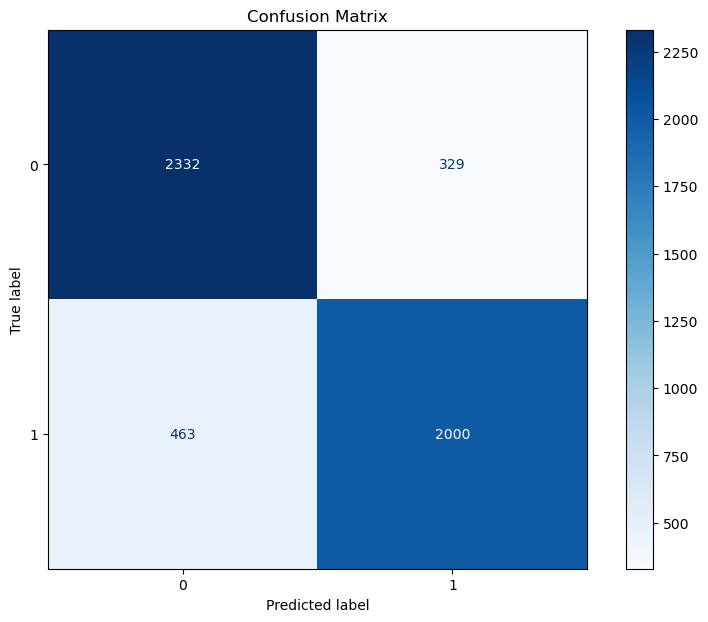

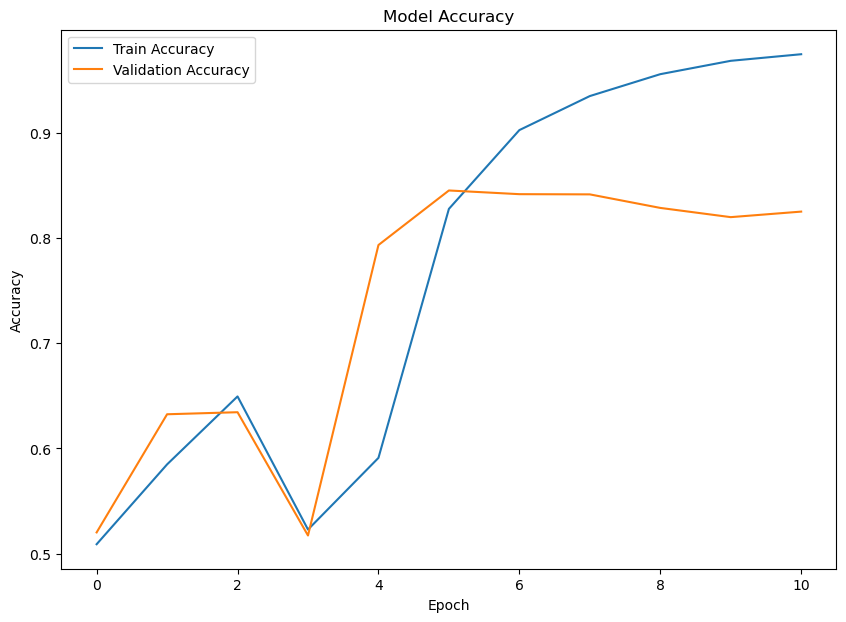

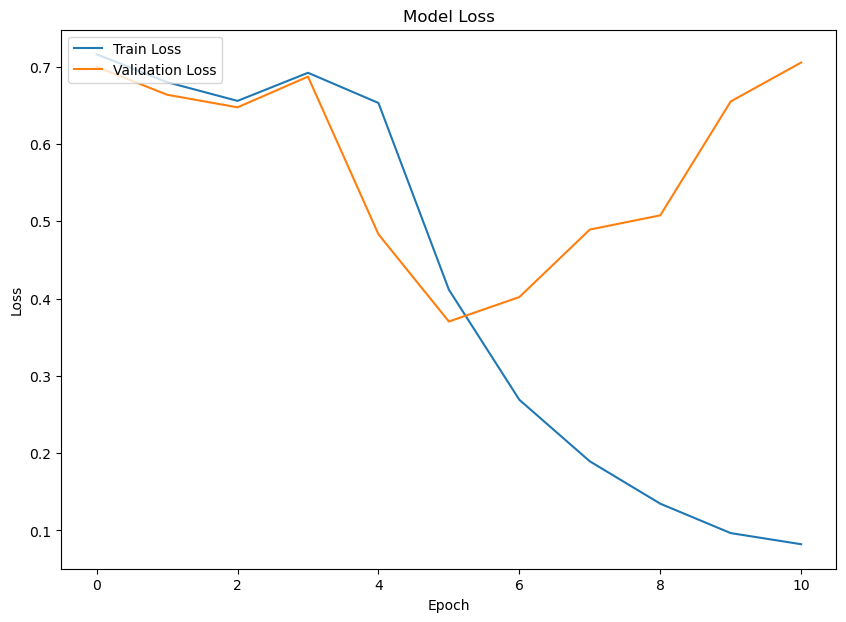

In [5]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import wordpunct_tokenize
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Ensure TensorFlow is using the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        tf.config.experimental.set_visible_devices(physical_devices, 'GPU')
    except:
        pass

# Create results folder if not exists
results_folder = "results"
os.makedirs(results_folder, exist_ok=True)

# Parameters
EPOCHS = 20
BATCH_SIZE = 64
MAX_LEN = 128
VOCAB_SIZE = 30522  # Typically the vocab size for BERT tokenizer

# Load the dataset
file_path = 'preprocessed_ut20k.csv'
dataset = pd.read_csv(file_path)

# Ensure no NaN values in 'comment' column
dataset.dropna(subset=['comment'], inplace=True)

# Split the dataset into features and labels
X = dataset['comment']
y = dataset['label']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# Label Encoder
encoder = LabelEncoder()

# Transform train and test labels
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Define custom stop words
freezing_words = ['ہے', 'ہیں', 'تھا', 'تھے', 'کے']

# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(
    analyzer='word',
    max_df=0.8,
    min_df=4,
    ngram_range=(1, 1),
    stop_words=freezing_words,
    sublinear_tf=True,
    tokenizer=wordpunct_tokenize
)

# Fit and transform the training data, then transform the testing data
train_data_x = tfidf.fit_transform(X_train)
test_data_x = tfidf.transform(X_test)

# Feature selection using chi2
chi2_fs = SelectKBest(chi2, k=MAX_LEN)
X_train_k = chi2_fs.fit_transform(train_data_x, y_train)
X_test_k = chi2_fs.transform(test_data_x)

# Convert sparse matrices to dense arrays
X_train_k = X_train_k.toarray()
X_test_k = X_test_k.toarray()

# Tokenize and encode sequences in the training and validation sets
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

def encode_texts(texts, max_len=MAX_LEN):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences

# Encode the texts
X_train_encoded = encode_texts(X_train)
X_test_encoded = encode_texts(X_test)

# Ensure y_train and y_test are numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Build the GRU model
inputs = Input(shape=(MAX_LEN,))
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN)(inputs)
gru = GRU(128, return_sequences=True)(embedding)
dropout = Dropout(0.3)(gru)
gru = GRU(64, return_sequences=True)(dropout)
dropout = Dropout(0.3)(gru)
gru = GRU(32)(dropout)
dropout = Dropout(0.3)(gru)
dense = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dropout)
dropout = Dropout(0.3)(dense)
outputs = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
print("Compiling GRU model...")
start_time = time.time()
history = model.fit(
    X_train_encoded, y_train,
    validation_data=(X_test_encoded, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)
end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")

# Evaluation
gru_train = model.evaluate(X_train_encoded, y_train)
gru_test = model.evaluate(X_test_encoded, y_test)

# Predictions
yhat_probs = model.predict(X_test_encoded, verbose=0)
yhat_classes = (yhat_probs > 0.5).astype("int32")

# Metrics
gru_accuracy = round(accuracy_score(y_test, yhat_classes), 2) * 100
gru_precision = round(precision_score(y_test, yhat_classes, average='macro'), 2) * 100
gru_recall = round(recall_score(y_test, yhat_classes, average='macro'), 2) * 100
gru_f1 = round(f1_score(y_test, yhat_classes, average='macro'), 2) * 100
gru_kappa = round(cohen_kappa_score(y_test, yhat_classes), 2) * 100

print(f"Accuracy: {gru_accuracy}%")
print(f"Precision: {gru_precision}%")
print(f"Recall: {gru_recall}%")
print(f"F1 Score: {gru_f1}%")
print(f"Cohen Kappa: {gru_kappa}%")

# Confusion Matrix
cm = confusion_matrix(y_test, yhat_classes)
print("Confusion Matrix:")
print(cm)

# Save confusion matrix plot
fig, ax = plt.subplots(figsize=(10, 7))  # Adjust the figsize for better resolution
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.savefig(os.path.join(results_folder, "gru_confusion_matrix.png"), dpi=300)
plt.show()

# Plot training history
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig(os.path.join(results_folder, "gru_accuracy.png"), dpi=300)
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig(os.path.join(results_folder, "gru_loss.png"), dpi=300)
plt.show()


/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 128, 128)       │     3,906,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_123 (GRU)                   │ (None, 128, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_164 (Dropout)           │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_124 (GRU)                   │ (None, 128, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_125 (GRU)                   │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,721 (15.47 MB)

 Trainable params: 4,054,721 (15.47 MB)

 Non-trainable params: 0 (0.00 B)

Compiling GRU model for k=500...
Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.5033 - loss: 0.7258 - val_accuracy: 0.5057 - val_loss: 0.7036
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5096 - loss: 0.7059 - val_accuracy: 0.6198 - val_loss: 0.6964
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.5697 - loss: 0.6860 - val_accuracy: 0.6948 - val_loss: 0.6429
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7112 - loss: 0.5911 - val_accuracy: 0.7233 - val_loss: 0.5482
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7790 - loss: 0.4804 - val_accuracy: 0.7795 - val_loss: 0.4960
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8745 - loss: 0.3228 - val_accuracy: 0.8333 - val_loss: 0.4316
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9217 - loss: 0.2140 - val_accuracy: 0.8400 - val_loss: 0.4476
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy

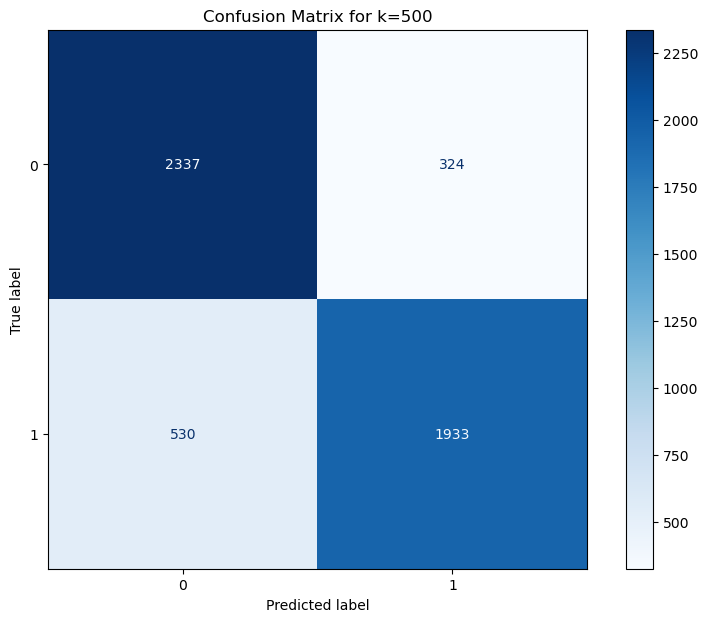

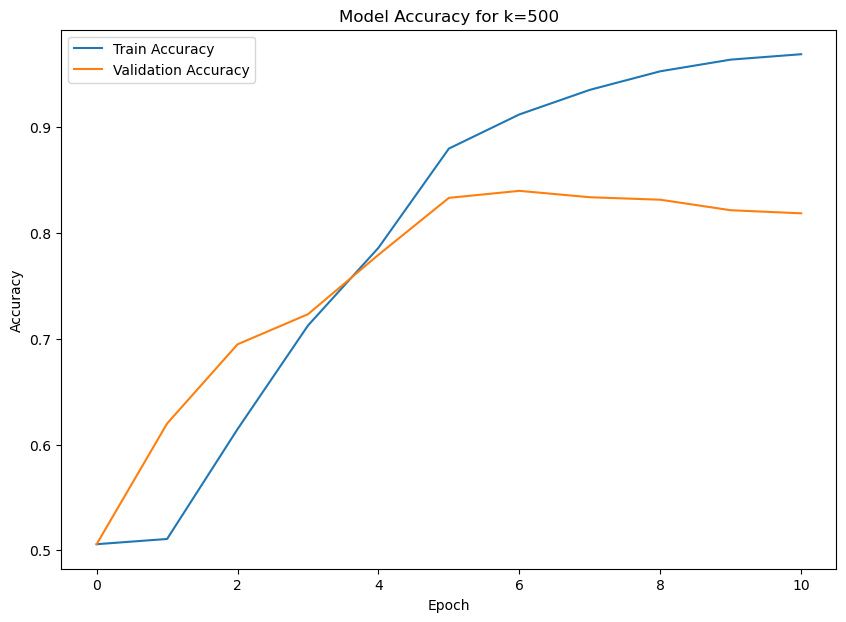

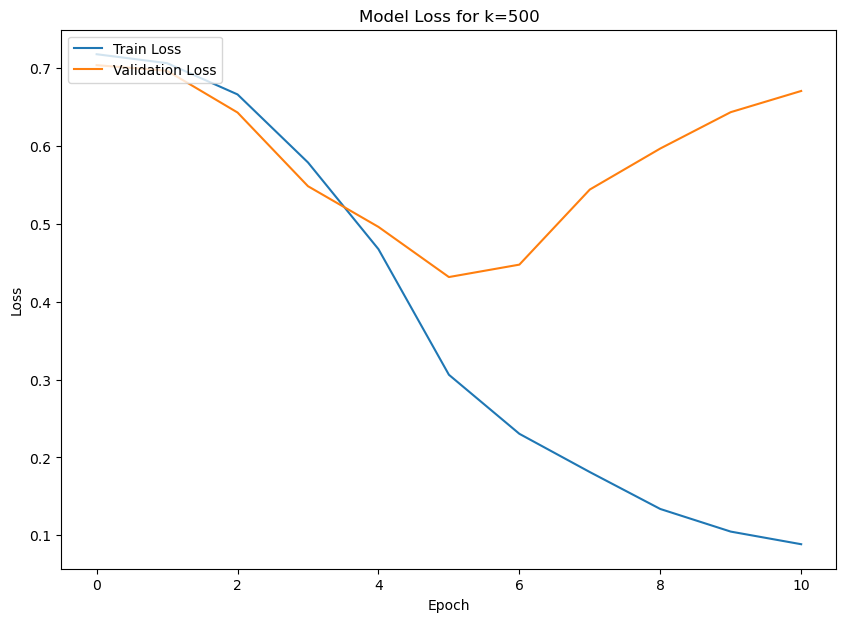

/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 128, 128)       │     3,906,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_126 (GRU)                   │ (None, 128, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_127 (GRU)                   │ (None, 128, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_128 (GRU)                   │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_171 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,721 (15.47 MB)

 Trainable params: 4,054,721 (15.47 MB)

 Non-trainable params: 0 (0.00 B)

Compiling GRU model for k=1000...
Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.5137 - loss: 0.7242 - val_accuracy: 0.5170 - val_loss: 0.6960
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5298 - loss: 0.6941 - val_accuracy: 0.6780 - val_loss: 0.6746
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.6799 - loss: 0.6139 - val_accuracy: 0.8275 - val_loss: 0.4326
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8584 - loss: 0.3634 - val_accuracy: 0.8445 - val_loss: 0.3707
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9142 - loss: 0.2403 - val_accuracy: 0.8456 - val_loss: 0.3953
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9370 - loss: 0.1840 - val_accuracy: 0.8368 - val_loss: 0.4622
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9582 - loss: 0.1321 - val_accuracy: 0.8365 - val_loss: 0.4981
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accurac

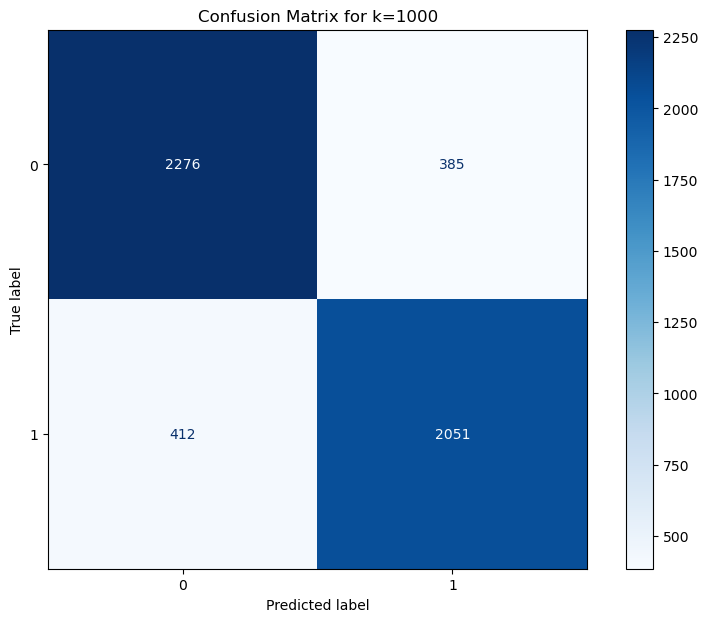

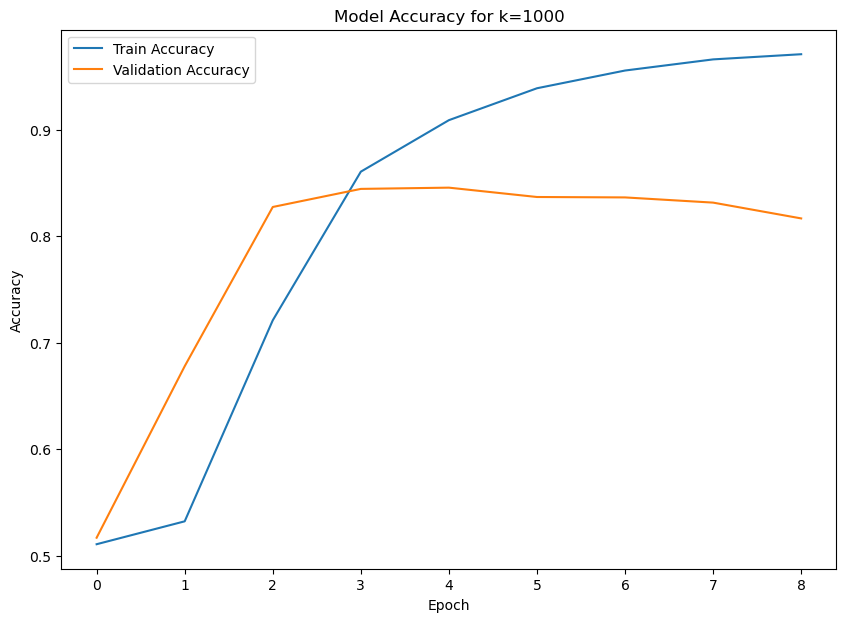

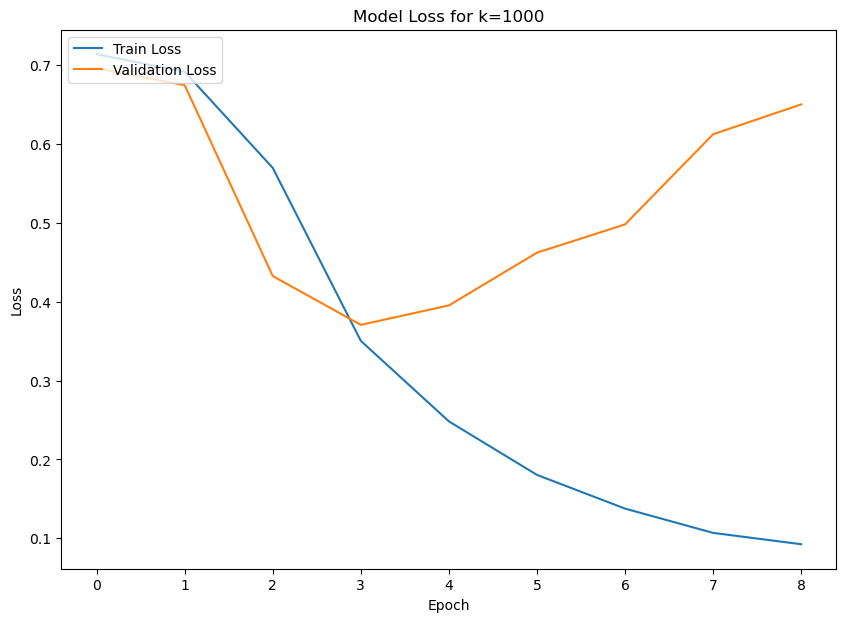

/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 128, 128)       │     3,906,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_129 (GRU)                   │ (None, 128, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_172 (Dropout)           │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_130 (GRU)                   │ (None, 128, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_173 (Dropout)           │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_131 (GRU)                   │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,721 (15.47 MB)

 Trainable params: 4,054,721 (15.47 MB)

 Non-trainable params: 0 (0.00 B)

Compiling GRU model for k=1500...
Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.5093 - loss: 0.7232 - val_accuracy: 0.5193 - val_loss: 0.6999
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5194 - loss: 0.6945 - val_accuracy: 0.5207 - val_loss: 0.6873
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5883 - loss: 0.6455 - val_accuracy: 0.8230 - val_loss: 0.4139
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8630 - loss: 0.3584 - val_accuracy: 0.8460 - val_loss: 0.3637
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9219 - loss: 0.2300 - val_accuracy: 0.8396 - val_loss: 0.4305
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9470 - loss: 0.1588 - val_accuracy: 0.8370 - val_loss: 0.4584
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9664 - loss: 0.1093 - val_accuracy: 0.8292 - val_loss: 0.5702
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accurac

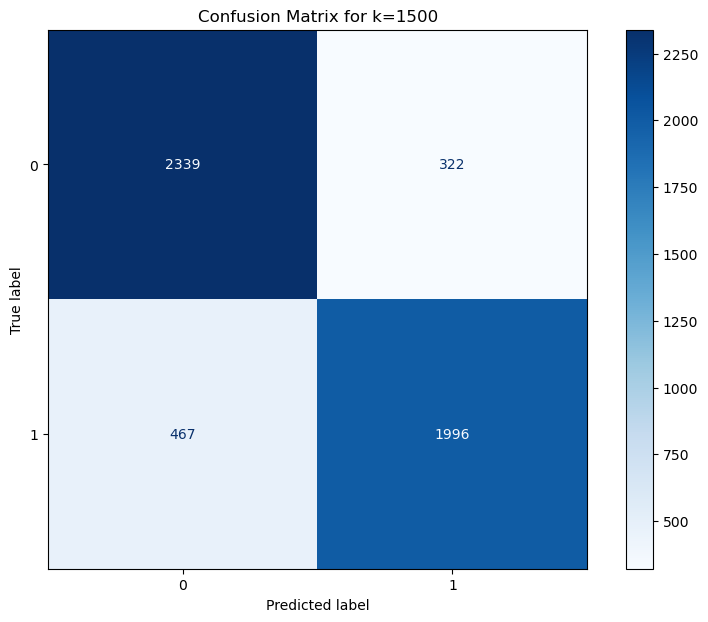

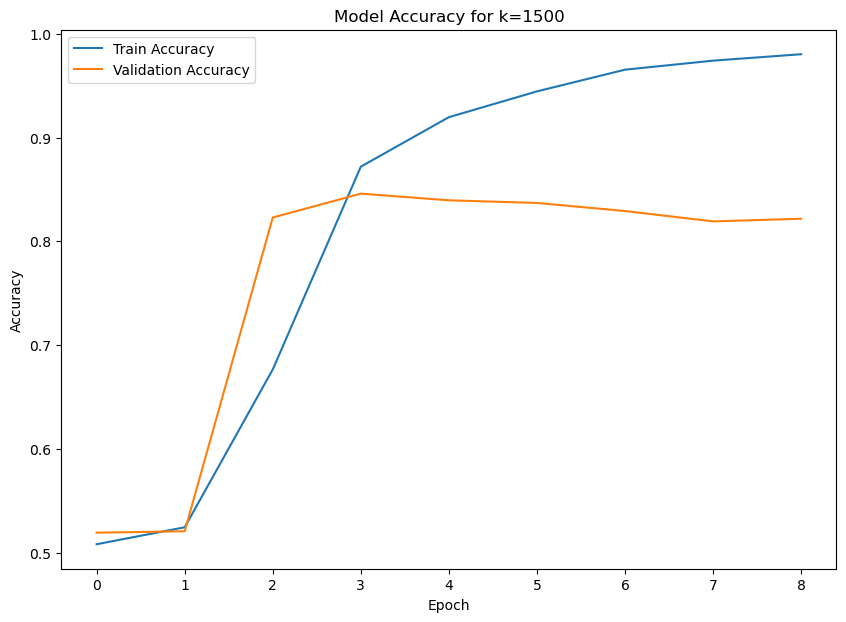

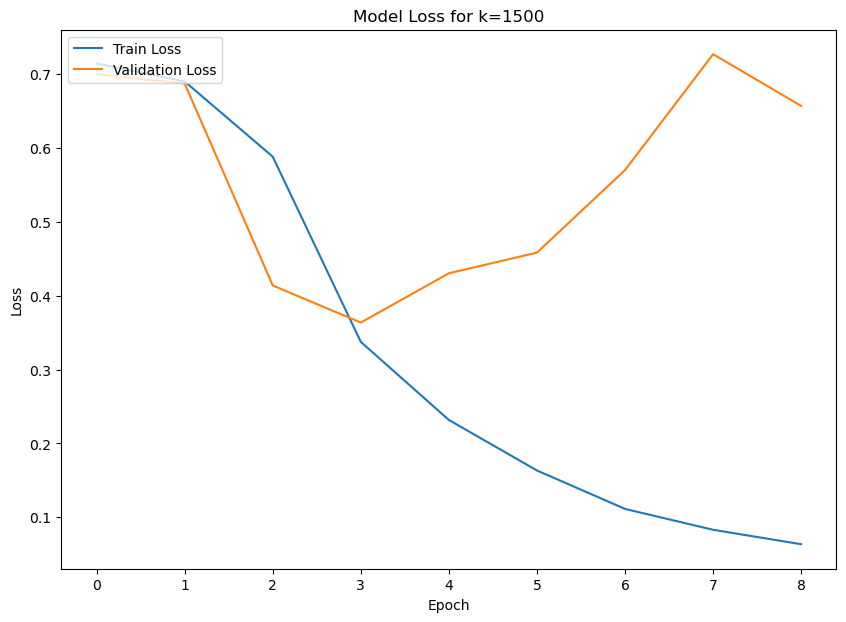

/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 128, 128)       │     3,906,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_132 (GRU)                   │ (None, 128, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_176 (Dropout)           │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_133 (GRU)                   │ (None, 128, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_177 (Dropout)           │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_134 (GRU)                   │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_178 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_179 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,721 (15.47 MB)

 Trainable params: 4,054,721 (15.47 MB)

 Non-trainable params: 0 (0.00 B)

Compiling GRU model for k=2000...
Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.5096 - loss: 0.7236 - val_accuracy: 0.5101 - val_loss: 0.6915
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5285 - loss: 0.6944 - val_accuracy: 0.5213 - val_loss: 0.6878
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.6486 - loss: 0.6202 - val_accuracy: 0.8234 - val_loss: 0.4120
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8709 - loss: 0.3419 - val_accuracy: 0.8427 - val_loss: 0.3785
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9263 - loss: 0.2157 - val_accuracy: 0.8376 - val_loss: 0.4086
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9516 - loss: 0.1578 - val_accuracy: 0.8333 - val_loss: 0.4766
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9613 - loss: 0.1231 - val_accuracy: 0.8259 - val_loss: 0.5676
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accurac

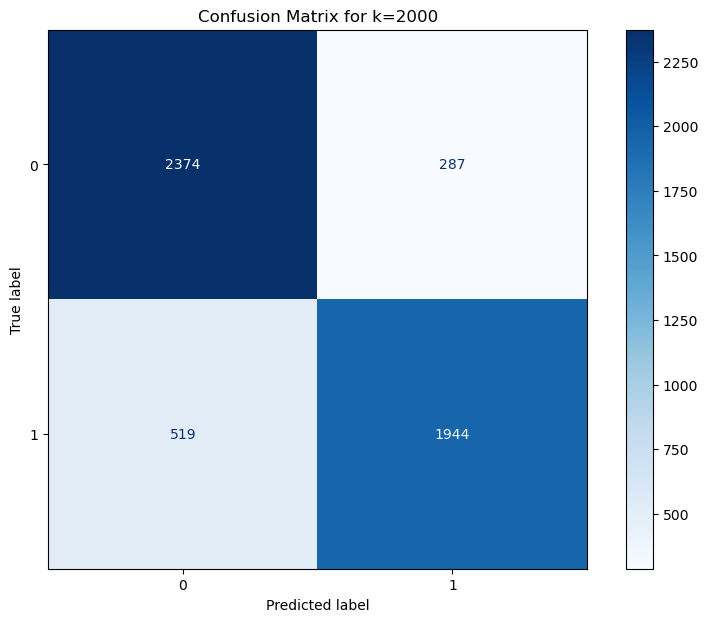

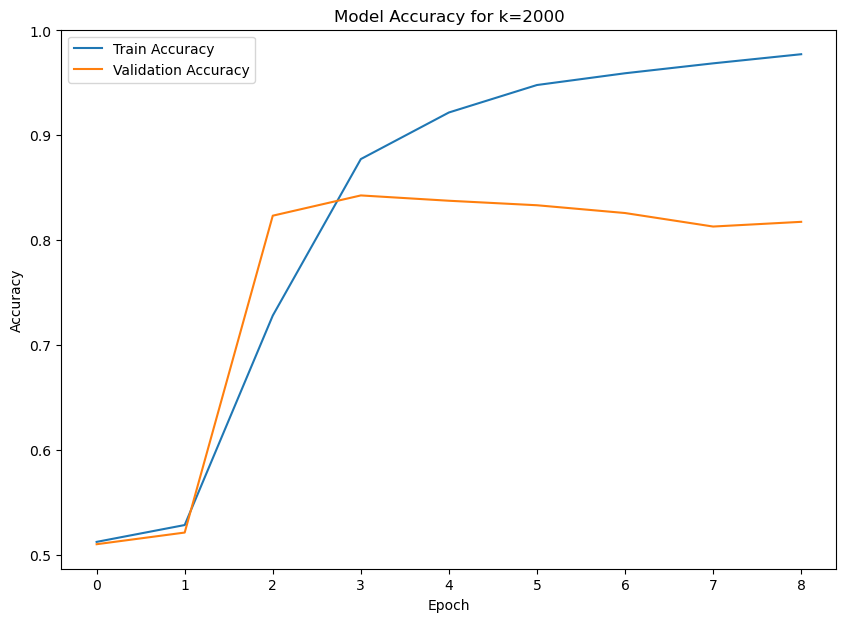

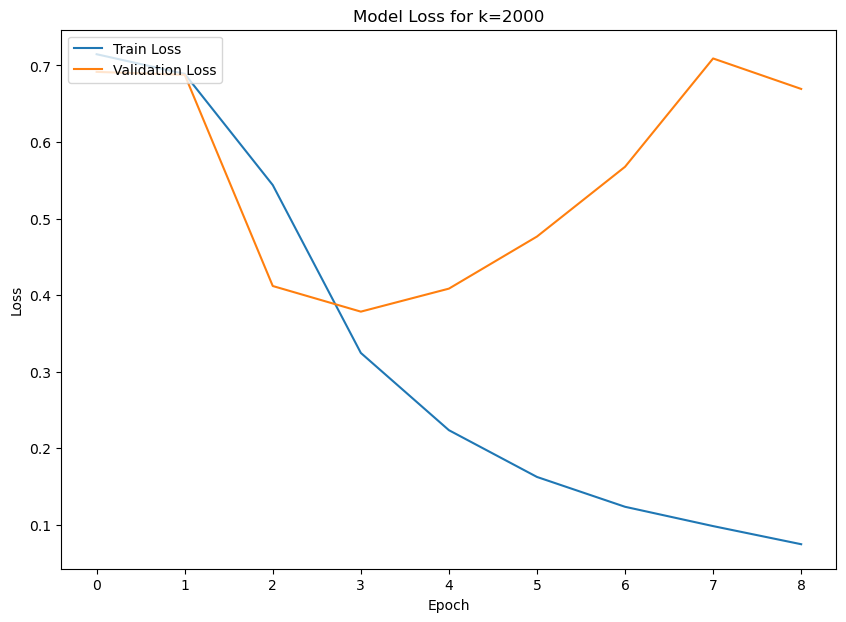

/home/foit-pc2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 128, 128)       │     3,906,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_135 (GRU)                   │ (None, 128, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_180 (Dropout)           │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_136 (GRU)                   │ (None, 128, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_181 (Dropout)           │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_137 (GRU)                   │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,721 (15.47 MB)

 Trainable params: 4,054,721 (15.47 MB)

 Non-trainable params: 0 (0.00 B)

Compiling GRU model for k=6243...
Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.5104 - loss: 0.7237 - val_accuracy: 0.5193 - val_loss: 0.6973
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5197 - loss: 0.6928 - val_accuracy: 0.5121 - val_loss: 0.6904
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.5466 - loss: 0.6669 - val_accuracy: 0.8072 - val_loss: 0.4447
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8331 - loss: 0.4029 - val_accuracy: 0.8406 - val_loss: 0.3603
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9134 - loss: 0.2440 - val_accuracy: 0.8324 - val_loss: 0.3894
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9410 - loss: 0.1773 - val_accuracy: 0.8310 - val_loss: 0.4460
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9628 - loss: 0.1248 - val_accuracy: 0.8269 - val_loss: 0.5630
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accurac

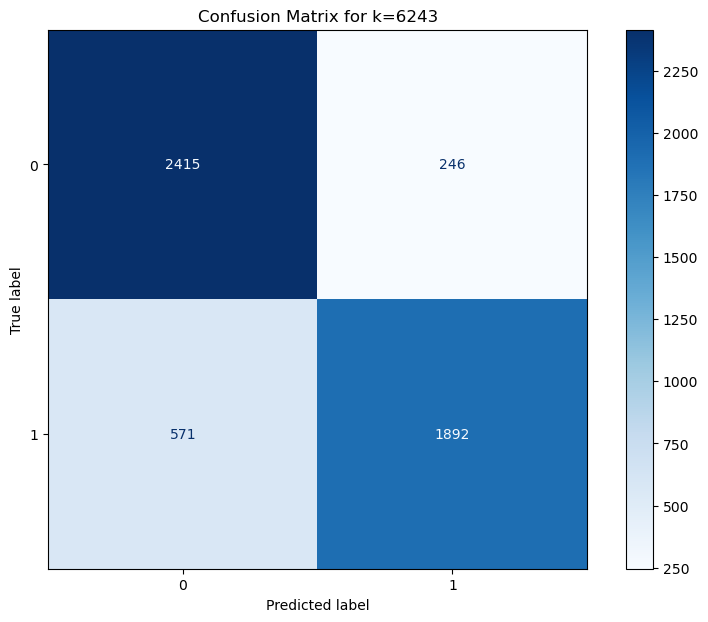

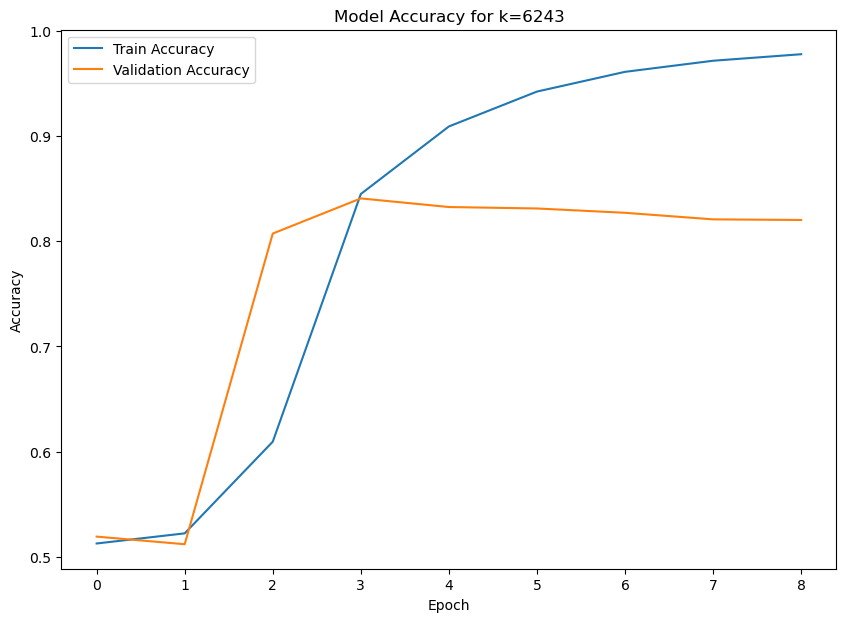

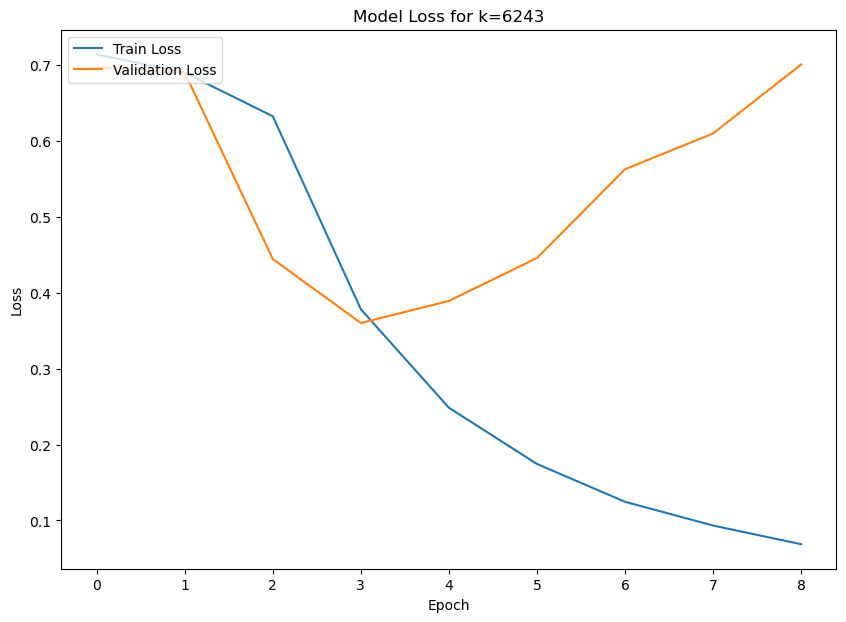

In [6]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import wordpunct_tokenize
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Ensure TensorFlow is using the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        tf.config.experimental.set_visible_devices(physical_devices, 'GPU')
    except:
        pass

# Create results folder if not exists
results_folder = "results"
os.makedirs(results_folder, exist_ok=True)

# Parameters
EPOCHS = 20
BATCH_SIZE = 64
MAX_LEN = 128
VOCAB_SIZE = 30522  # Typically the vocab size for BERT tokenizer
FEATURE_COUNTS = [500, 1000, 1500, 2000, 'all']

# Load the dataset
file_path = 'preprocessed_ut20k.csv'
dataset = pd.read_csv(file_path)

# Ensure no NaN values in 'comment' column
dataset.dropna(subset=['comment'], inplace=True)

# Split the dataset into features and labels
X = dataset['comment']
y = dataset['label']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# Label Encoder
encoder = LabelEncoder()

# Transform train and test labels
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Define custom stop words
freezing_words = ['ہے', 'ہیں', 'تھا', 'تھے', 'کے']

# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(
    analyzer='word',
    max_df=0.8,
    min_df=4,
    ngram_range=(1, 1),
    stop_words=freezing_words,
    sublinear_tf=True,
    tokenizer=wordpunct_tokenize
)

# Fit and transform the training data, then transform the testing data
train_data_x = tfidf.fit_transform(X_train)
test_data_x = tfidf.transform(X_test)

for k in FEATURE_COUNTS:
    if k == 'all':
        k = train_data_x.shape[1]  # Use all features if 'all' is specified

    # Feature selection using chi2
    chi2_fs = SelectKBest(chi2, k=k)
    X_train_k = chi2_fs.fit_transform(train_data_x, y_train)
    X_test_k = chi2_fs.transform(test_data_x)

    # Convert sparse matrices to dense arrays
    X_train_k = X_train_k.toarray()
    X_test_k = X_test_k.toarray()

    # Tokenize and encode sequences in the training and validation sets
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(X_train)

    def encode_texts(texts, max_len=MAX_LEN):
        sequences = tokenizer.texts_to_sequences(texts)
        padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding='post')
        return padded_sequences

    # Encode the texts
    X_train_encoded = encode_texts(X_train)
    X_test_encoded = encode_texts(X_test)

    # Ensure y_train and y_test are numpy arrays
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Build the GRU model
    inputs = Input(shape=(MAX_LEN,))
    embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN)(inputs)
    gru = GRU(128, return_sequences=True)(embedding)
    dropout = Dropout(0.3)(gru)
    gru = GRU(64, return_sequences=True)(dropout)
    dropout = Dropout(0.3)(gru)
    gru = GRU(32)(dropout)
    dropout = Dropout(0.3)(gru)
    dense = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dropout)
    dropout = Dropout(0.3)(dense)
    outputs = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs, outputs)

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    model.summary()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Training the model
    print(f"Compiling GRU model for k={k}...")
    start_time = time.time()
    history = model.fit(
        X_train_encoded, y_train,
        validation_data=(X_test_encoded, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping]
    )
    end_time = time.time()

    print(f"Training time for k={k}: {end_time - start_time:.2f} seconds")

    # Evaluation
    gru_train = model.evaluate(X_train_encoded, y_train)
    gru_test = model.evaluate(X_test_encoded, y_test)

    # Predictions
    yhat_probs = model.predict(X_test_encoded, verbose=0)
    yhat_classes = (yhat_probs > 0.5).astype("int32")

    # Metrics
    gru_accuracy = round(accuracy_score(y_test, yhat_classes), 2) * 100
    gru_precision = round(precision_score(y_test, yhat_classes, average='macro'), 2) * 100
    gru_recall = round(recall_score(y_test, yhat_classes, average='macro'), 2) * 100
    gru_f1 = round(f1_score(y_test, yhat_classes, average='macro'), 2) * 100
    gru_kappa = round(cohen_kappa_score(y_test, yhat_classes), 2) * 100

    print(f"Results for k={k}:")
    print(f"Accuracy: {gru_accuracy}%")
    print(f"Precision: {gru_precision}%")
    print(f"Recall: {gru_recall}%")
    print(f"F1 Score: {gru_f1}%")
    print(f"Cohen Kappa: {gru_kappa}%")

    # Confusion Matrix
    cm = confusion_matrix(y_test, yhat_classes)
    print(f"Confusion Matrix for k={k}:")
    print(cm)

    # Save confusion matrix plot
    fig, ax = plt.subplots(figsize=(10, 7))  # Adjust the figsize for better resolution
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(f"Confusion Matrix for k={k}")
    plt.savefig(os.path.join(results_folder, f"gru_confusion_matrix_k_{k}.png"), dpi=300)
    plt.show()

    # Plot training history
    plt.figure(figsize=(10, 7))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy for k={k}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.savefig(os.path.join(results_folder, f"gru_accuracy_k_{k}.png"), dpi=300)
    plt.show()

    plt.figure(figsize=(10, 7))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for k={k}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.savefig(os.path.join(results_folder, f"gru_loss_k_{k}.png"), dpi=300)
    plt.show()


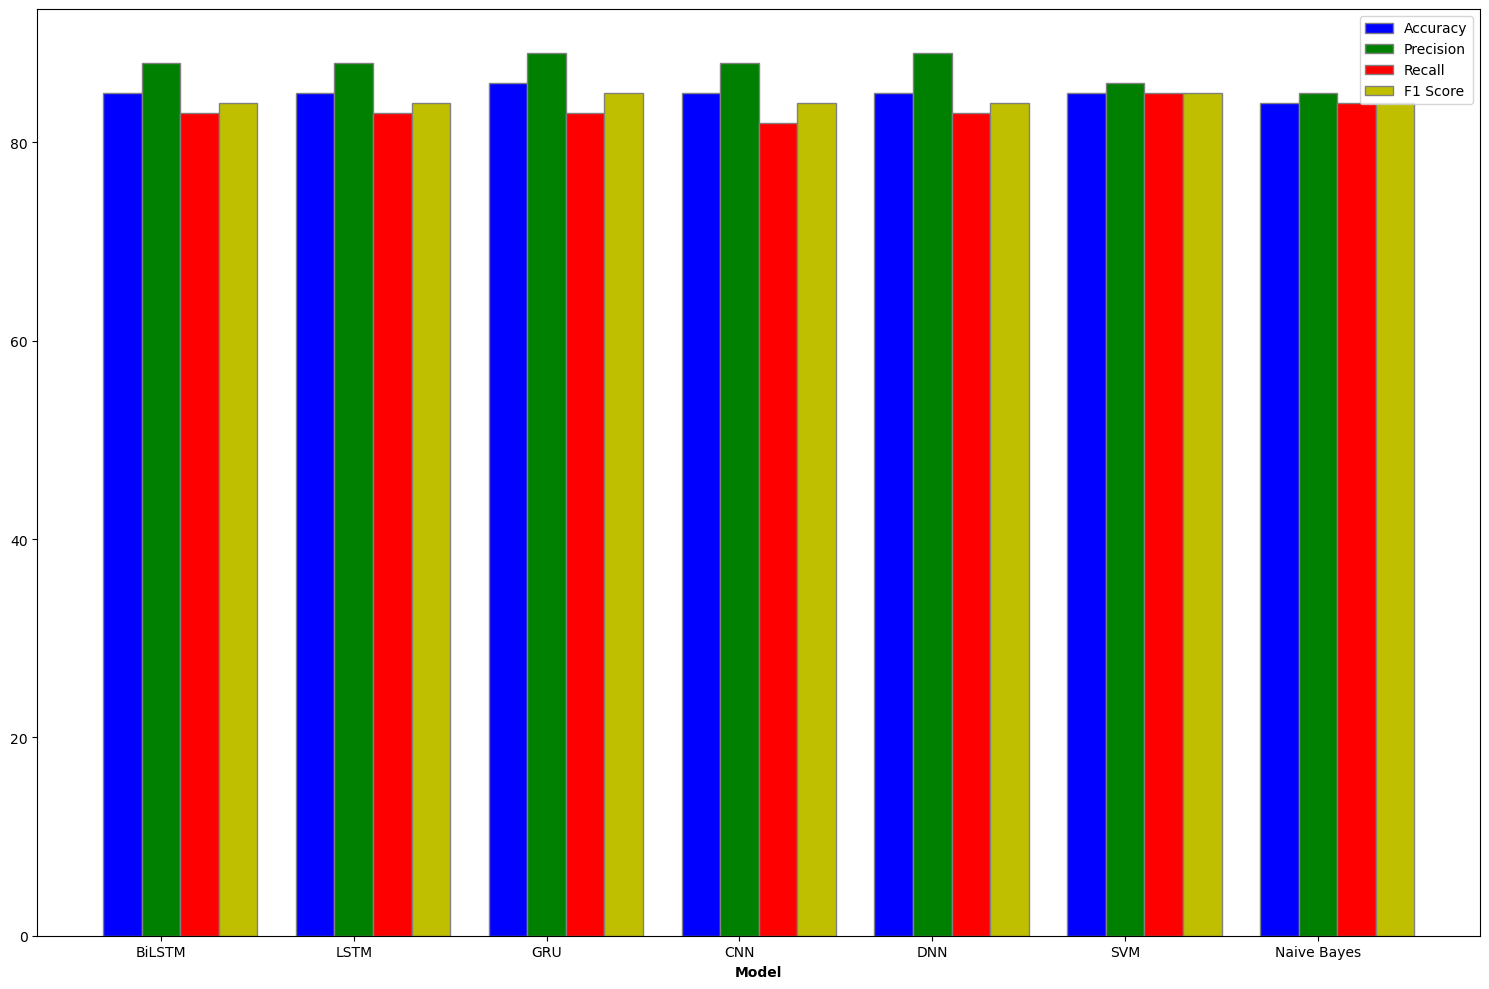

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data for the tables
best_values = {
    "Model": ["BiLSTM", "LSTM", "GRU", "CNN", "DNN", "SVM", "Naive Bayes"],
    "Accuracy": [85.0, 85.0, 86.0, 85.0, 85.0, 85.0, 84.0],
    "Precision": [88.0, 88.0, 89.0, 88.0, 89.0, 86.0, 85.0],
    "Recall": [83.0, 83.0, 83.0, 82.0, 83.0, 85.0, 84.0],
    "F1 Score": [84.0, 84.0, 85.0, 84.0, 84.0, 85.0, 84.0]
}

# Convert to DataFrame
df_best = pd.DataFrame(best_values)

# Plotting the graph
fig, ax = plt.subplots(figsize=(15, 10), facecolor='w')

# Set position of bar on X axis
barWidth = 0.2
r1 = np.arange(len(df_best["Model"]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
plt.bar(r1, df_best["Accuracy"], color='b', width=barWidth, edgecolor='grey', label='Accuracy')
plt.bar(r2, df_best["Precision"], color='g', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r3, df_best["Recall"], color='r', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r4, df_best["F1 Score"], color='y', width=barWidth, edgecolor='grey', label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(df_best["Model"]))], df_best["Model"])

# Create legend & Show graphic
plt.legend()
plt.tight_layout()

# Save the figure with white background
fig.patch.set_facecolor('white')
plt.savefig("best_model_performance_metrics_white_bg.png", dpi=300, bbox_inches='tight')
plt.show()
